# Chapter 3. Classification

## MNIST
Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']
print('X size', X.shape)
print('label size:', y.shape)

X size (70000, 784)
label size: (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s `imshow()` function:

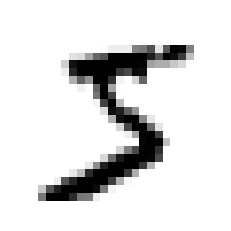

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].values
some_digits_image = some_digit.reshape(28, 28)

plt.imshow(some_digits_image, cmap='binary')
plt.axis("off")
plt.show()

In [40]:
print(y[0])

5


In [41]:
# Let's cast labels as integers
import numpy as np

y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [42]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's try to identify only one digit "5". This will be an example of _binary classifier_, capable of distibuishing between just two classes, 5 and not-5.

In [43]:
# Set for all 5s
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a _Stochastic Gradient Descent (SGD)_ classifier. This classifier deals with large datasets efficiently, because it deals with training instances independetly, one at a time.

In [52]:
from sklearn.linear_model import SGDClassifier

sdg_clf = SGDClassifier(random_state=42)
sdg_clf.fit(X_train, y_train_5)

# Predicting if the digit is 5
sdg_clf.predict([some_digit])

array([ True])

## Performance Measures